In [1]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz 

--2019-10-10 02:20:56--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G   812KB/s    in 23m 11s 

2019-10-10 02:44:08 (860 KB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [0]:
!tar xvzf genres.tar.gz

In [3]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [4]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 720x720 with 0 Axes>

In [0]:
try:
    os.mkdir('./all-genres')
    os.mkdir('./all-genres/training')
    os.mkdir('./all-genres/testing')
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    for g in genres:
      os.mkdir(f'./all-genres/training/{g}')
      os.mkdir(f'./all-genres/testing/{g}')
except OSError:
    pass

In [0]:
from shutil import copyfile
import random

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

        
split_size = .9
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
  GENRE_SOURCE_DIR = f'./img_data/{g}/'
  GENRE_TARGET_TEST_DIR=f'./all-genres/testing/{g}/'
  GENRE_TARGET_TRAIN_DIR=f'./all-genres/training/{g}/'
  split_data(GENRE_SOURCE_DIR, GENRE_TARGET_TRAIN_DIR, GENRE_TARGET_TEST_DIR, split_size)      




# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [0]:
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras import Sequential
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [0]:
curr_session = tf.get_default_session()
# close current session
if curr_session is not None:
    curr_session.close()
# reset graph
K.clear_session()
# create new session
s = tf.InteractiveSession()
K.set_session(s)


model = Sequential()

In [0]:
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(192, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 128)     36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 192)      

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [0]:
train_dir = './all-genres/training/'
validation_dir = './all-genres/testing/' 

In [27]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (300, 300))

Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [41]:
history1 = model.fit_generator(train_generator, epochs=50, validation_data = validation_generator, verbose = 1)

Epoch 1/50
45/45 [==============================] - 18s 394ms/step - loss: 2.3312 - acc: 0.0978 - val_loss: 2.3039 - val_acc: 0.1000
Epoch 2/50
45/45 [==============================] - 17s 377ms/step - loss: 2.3010 - acc: 0.1167 - val_loss: 2.2883 - val_acc: 0.1200
Epoch 3/50
45/45 [==============================] - 17s 374ms/step - loss: 2.2343 - acc: 0.1667 - val_loss: 2.1363 - val_acc: 0.2900
Epoch 4/50
45/45 [==============================] - 17s 373ms/step - loss: 2.0617 - acc: 0.2456 - val_loss: 1.9746 - val_acc: 0.3000
Epoch 5/50
45/45 [==============================] - 17s 380ms/step - loss: 1.9317 - acc: 0.2889 - val_loss: 1.8388 - val_acc: 0.3000
Epoch 6/50
45/45 [==============================] - 17s 373ms/step - loss: 1.9167 - acc: 0.3100 - val_loss: 1.7494 - val_acc: 0.4300
Epoch 7/50
45/45 [==============================] - 17s 373ms/step - loss: 1.7633 - acc: 0.3378 - val_loss: 1.6839 - val_acc: 0.3900
Epoch 8/50
45/45 [==============================] - 17s 373ms/step - 

KeyboardInterrupt: ignored

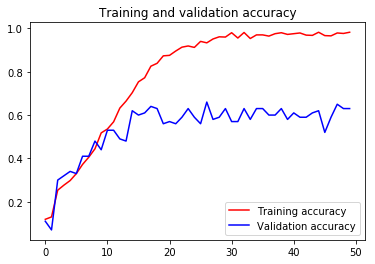

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()